In [ ]:
!pip install -qU datasets soundfile speechbrain accelerate transformers

# Text to Speech

**Text-to-Speech (TTS)** is the task of creating natural-sounding speech from text, where the speech can be generated in multiple languages and for multiple speakers.

We will fine-tune **SpeechT5** that was originally trained on English speech on the Dutch (`nl`) language subset of the **VoxPopuli** dataset.

## Load the dataset

**VoxPopuli** is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recodings. It contains labelled audio-transcription data for 15 European languages.

In [ ]:
from datasets import load_dataset, Audio

# load the Dutch language subset
dataset = load_dataset(
    'facebook/voxpopuli',
    'nl',
    split='train',
    trust_remote_code=True
)
len(dataset)

**SpeechT5** expects audio data to have a sampling rate of 16kHz, so we need to make sure the examples in the dataset meet this requirement:

In [5]:
dataset = dataset.cast_column(
    'audio',
    Audio(sampling_rate=16_000)
)

## Preprocess the data

In [6]:
from transformers import SpeechT5Processor

checkpoint = 'microsoft/speecht5_tts'
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

### Text cleanup for SpeechT5 tokenization

In [7]:
# extract the tokenizer for laster use
tokenizer = processor.tokenizer

In [10]:
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

In [9]:
dataset.features

{'audio_id': Value(dtype='string', id=None),
 'language': ClassLabel(names=['en', 'de', 'fr', 'es', 'pl', 'it', 'ro', 'hu', 'cs', 'nl', 'fi', 'hr', 'sk', 'sl', 'et', 'lt', 'en_accented'], id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_text': Value(dtype='string', id=None),
 'normalized_text': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='string', id=None),
 'is_gold_transcript': Value(dtype='bool', id=None),
 'accent': Value(dtype='string', id=None)}

In [11]:
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/94ad18362007da652ce6c405177dd65cc2711a93d5a8f5a6e07b111bd2c47d29/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

The dataset examples contain `raw_text` and `normalized_text` features. For the SpeechT5 tokenizer, it does NOT have any tokens for numbers. In `normalized_text` the numbers are written out as text. Thus, we will use `noramlized_text` as the text input.

Since SpeechT5 was trained on the English language, it may not recognize certain characters in the Dutch dataset and convert them to `<unk>` tokens.

we need to extract all unique characters in the dataset using the `SpecchT5Tokenizer` which works with characters as tokens to identify unsupported tokens:


In [12]:
def extract_all_chars(batch):
    all_text = " ".join(batch['normalized_text'])
    vocab = list(set(all_text))
    return {'vocab': [vocab], 'all_text': [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)
vocabs

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Dataset({
    features: ['vocab', 'all_text'],
    num_rows: 1
})

In [13]:
dataset_vocab = set(vocabs['vocab'][0])
tokenizer_vocab = {k for k, v in tokenizer.get_vocab().items()}

Now we have two sets of characters:
* `dataset_vocab`: vocabulary from the dataset
* `tokenizer_vocab`: vocabulary from the tokenizer

When we take the difference between these two sets, The resulting set will contain the characters that are in the dataset but not in the tokenizer:

In [14]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

To handle the unsupported characters identified in the previous step, we need to define a function that maps these characters to valid tokens:

In [15]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs['normalized_text'] = inputs['normalized_text'].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

### Speakers

The `VoxPopuli` dataset includes speech from multiple speakers. To determine the number of speakers in the dataset, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset.

In [16]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset['speaker_id']:
    speaker_counts[speaker_id] += 1

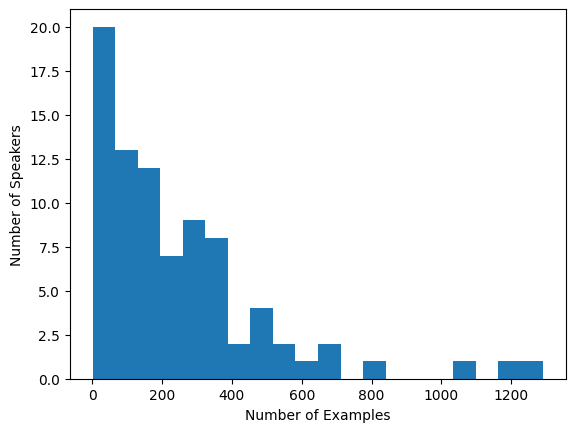

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.xlabel('Number of Examples')
plt.ylabel('Number of Speakers')
plt.show()

The histogram reveals that approximately 1/3 of the speakers in the dataset have fewer than 100 examples, while around 10 speakers have more than 500 examples.

In [18]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

# filter data
dataset = dataset.filter(
    select_speaker,
    input_columns=['speaker_id']
)

print(f"Number of speakers remained: {len(set(dataset['speaker_id']))}")

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

Number of speakers remained: 42


In [19]:
print(f"Number of examples remained: {len(dataset)}")

Number of examples remained: 9973


### Speaker embeddings

To enable the TTS model to differentiate between multiple speakers, we need to create a speaker embedding for each example. The speaker embedding is an additional input into the model that captures a particular speaker's voice characteristics. We will use the pretrained `spkrec-xvect-voxceleb` model from SpeechBrain to generate these speaker embeddings.

In [ ]:
import os
import torch
from speechbrain.inference.classifiers import EncoderClassifier
from accelerate.test_utils.testing import get_backend

spk_model_name = 'speechbrain/spkrec-xvect-voxceleb'
device, _, _ = get_backend()

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={'device': device},
    savedir=os.path.join('/tmp', spk_model_name)
)

In [21]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()

    return speaker_embeddings

The `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, whereas the training examples here are in Dutch.

For optimal results, we have to train an X-vector model on the target speech first, which will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language.

### Processing the dataset

In [22]:
def prepare_dataset(example):
    audio = example['audio']

    example = processor(
        text=example['normalized_text'],
        audio_target=audio['array'],
        sampling_rate=audio['sampling_rate'],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example['labels'] = example['labels'][0]
    # use SpeechBrain to obtain x-vector
    example['speaker_embeddings'] = create_speaker_embedding(audio['array'])

    return example

In [23]:
# verify the processing step
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

Speaker embeddings should be a 512-element vector:

In [24]:
processed_example['speaker_embeddings'].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

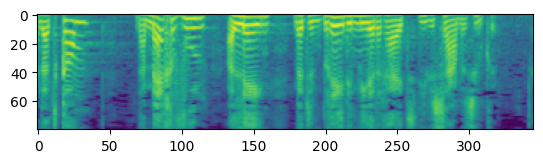

(345, 80)

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example['labels'].T)
plt.show()
processed_example['labels'].shape

Now we can apply to the entire dataset.

In [26]:
dataset = dataset.map(
    prepare_dataset,
    remove_columns=dataset.column_names
)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


We may see a warning that some examples in the dataset are longer than the maximum input length the model can handle (600 tokens). We have to remove those from the dataset.

In [27]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(
    is_not_too_long,
    input_columns=['input_ids']
)
len(dataset)

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

8259

In [28]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 7433
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 826
    })
})

### Data collator

In order to combine multiple examples into a batch, we need to define a custom data collator. This collator will pad shorter sequences with padding tokens, ensuring all examples have the same length in a batch.

In [29]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{'input_ids': feature['input_ids']} for feature in features]
        label_features = [{'input_values': feature['labels']} for feature in features]
        speaker_features = [feature['speaker_embeddings'] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors='pt'
        )

        # replace padding with -100 to ignore loss correctly
        batch['labels'] = batch['labels'].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1),
            -100
        )

        # not used during fine-tuning
        del batch['decoder_attention_mask']

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature['input_values']) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch['labels'] = batch['labels'][:, :max_length]

        # also add in the speaker embeddings
        batch['speaker_embeddings'] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. It throws away every other timestep from the target sequence. The decoder then predicts that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [30]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the model

In [ ]:
from transformers import SpeechT5ForTextSpeech

model = SpeechT5ForTextSpeech.from_pretrained(checkpoint)
# set `use_cache=False` to enable gradient checkpointing
model.config.use_cache = False

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    processing_class=processor,
)

In [ ]:
trainer.train()

## Inference

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-to-speech",
    model="<username>/speecht5_finetuned_voxpopuli_nl"
)

Initialize a text in Dutch we would like to narrate

In [ ]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

TO use SpeechT5 with the pipeline, we ned a speaker embedding. We can get it from an example in the test dataset

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
forward_params = {"speaker_embeddings": speaker_embeddings}
output = pipe(text, forward_params=forward_params)
output

In [ ]:
# listen the result
from IPython.display import Audio
Audio(output['audio'], rate=output['sampling_rate'])

We can also run the inference manually

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("YOUR_ACCOUNT/speecht5_finetuned_voxpopuli_nl")

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"
inputs = processor(text=text, return_tensors="pt")

We can also create a spectrogram:

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, we use the vocoder to turn the spectrogram into sound

In [ ]:
from IPython.display import Audio

with torch.no_grad():
    speech = vocoder(spectrogram)

Audio(speech.numpy(), rate=16000)